In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from numpy import asarray

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
!ls ../../data

clean_wells.csv features.csv    target.csv


In [4]:
df = pd.read_csv('../../data/clean_wells.csv')
df

,Unnamed: 0,amount_tsh,gps_height,basin,region,population,construction_year,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,status_group,near_pop,level,has_static,has_year
0,0,6000.0,1390,Lake Nyasa,Iringa,109,1999,gravity,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional,True,above,True,True
1,1,0.0,1399,Lake Victoria,Mara,280,2010,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,True,above,False,True
2,2,25.0,686,Pangani,Manyara,250,2009,gravity,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe,functional,True,above,True,True
3,3,0.0,263,Ruvuma / Southern Coast,Mtwara,58,1986,submersible,vwc,user-group,never pay,good,dry,borehole,groundwater,communal standpipe,non functional/needs repair,True,above,False,True
4,4,0.0,0,Lake Victoria,Kagera,0,0,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional,False,level,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,59395,10.0,1210,Pangani,Kilimanjaro,125,1999,gravity,water board,user-group,per bucket,good,enough,spring,groundwater,communal standpipe,functional,True,above,True,True
59396,59396,4700.0,1212,Rufiji,Iringa,56,1996,gravity,vwc,user-group,annually,good,enough,river/lake,surface,communal standpipe,functional,True,above,True,True
59397,59397,0.0,0,Rufiji,Mbeya,0,0,handpump,vwc,user-group,monthly,fluoride,enough,borehole,groundwater,hand pump,functional,False,level,False,False
59398,59398,0.0,0,Rufiji,Dodoma,0,0,handpump,vwc,user-group,never pay,good,insufficient,shallow well,groundwater,hand pump,functional,False,level,False,False


Cleaning out irrelevant data that would add noise to our model. 

In [46]:
final_df = df.drop(columns = ['Unnamed: 0','amount_tsh', 'gps_height', 'population', 
                              'construction_year', 'has_year'])

In [47]:
X = final_df.drop(columns = ['status_group'])
y = final_df['status_group']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

The following cells are used to construct a Pipeline for my numerical data and OneHotEncode my categorical data.

In [48]:
#https://stackoverflow.com/questions/61641852/what-is-the-valid-specification-of-the-columns-needed-for-sklearn-classifier-p

cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

In [49]:
num_trans = Pipeline(steps=[
    ('scaler', StandardScaler())
])
cat_trans = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                          sparse=False))
])

In [50]:
pp = ColumnTransformer(transformers=[
    ('num', num_trans, num_cols),
    ('cat', cat_trans, cat_cols)
])

In [51]:
pp.fit(X_train)
X_tr_pp = pp.transform(X_train)
X_te_pp = pp.transform(X_test)

I ran 6 different models to see which ones would perform the best on our dataset. We're looking to see which model did the best with handling false positives which is shown in our confusion matrix. 

## Model 1: KNN 

In [52]:
knn = KNeighborsClassifier(3)

knn.fit(X_tr_pp, y_train)

KNeighborsClassifier(n_neighbors=3)

In [53]:
scores = cross_val_score(estimator=knn, X=X_tr_pp,
                y=y_train, cv=5)
print(f"Median score: {np.median(scores):.4f} (+/- {np.std(scores):.4f})")

Median score: 0.7437 (+/- 0.0060)


In [54]:
knn.score(X_te_pp, y_test)

0.7394612794612795

In [55]:
knn.score(X_tr_pp, y_train)

0.7770370370370371

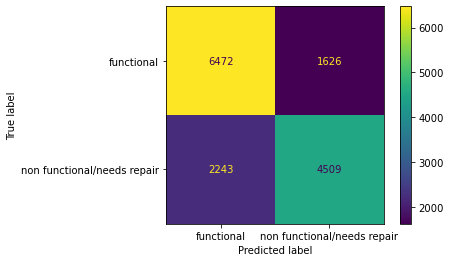

In [56]:
plot_confusion_matrix(knn, X_te_pp, y_test);

## Model 2: Decision Tree

In [16]:
dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_tr_pp, y_train)

DecisionTreeClassifier(random_state=42)

In [17]:
scores = cross_val_score(estimator=dt, X=X_tr_pp,
                         y=y_train, cv=5)
print(f"Median score: {np.median(scores):.4f} (+/- {np.std(scores):.4f})")

Median score: 0.7773 (+/- 0.0056)


In [18]:
dt.score(X_te_pp, y_test)

0.7788552188552188

In [19]:
dt.score(X_tr_pp, y_train)

0.8295622895622896

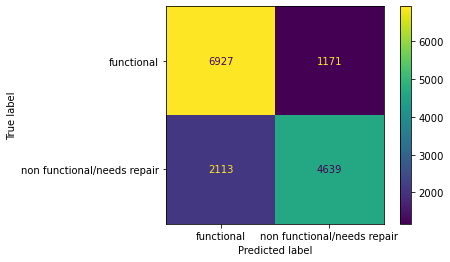

In [20]:
plot_confusion_matrix(dt, X_te_pp, y_test);

## Model 3: Logistic Regression

In [21]:
lr = LogisticRegression(max_iter=1000, random_state=42)

lr.fit(X_tr_pp, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [22]:
scores = cross_val_score(estimator=lr, X=X_tr_pp,
                         y=y_train, cv=5)
print(f"Median score: {np.median(scores):.4f} (+/- {np.std(scores):.4f})")

Median score: 0.7420 (+/- 0.0057)


In [23]:
lr.score(X_te_pp, y_test)

0.7423569023569023

In [24]:
lr.score(X_tr_pp, y_train)

0.7427609427609427

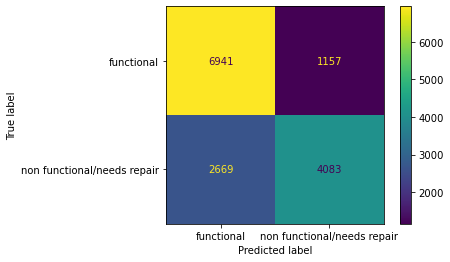

In [25]:
plot_confusion_matrix(lr, X_te_pp, y_test);

## Model 4: Random Forest

In [75]:
rfc = RandomForestClassifier(random_state=42, n_estimators=150, max_depth=30, min_samples_leaf=7)

rfc.fit(X_tr_pp, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=7, n_estimators=150,
                       random_state=42)

In [76]:
scores = cross_val_score(estimator=rfc, X=X_tr_pp,
                         y=y_train, cv=9)
print(f"Median score: {np.median(scores):.4f} (+/- {np.std(scores):.4f})")

Median score: 0.7768 (+/- 0.0075)


In [77]:
rfc.score(X_te_pp, y_test)

0.7744107744107744

In [78]:
rfc.score(X_tr_pp, y_train)

0.7898316498316499

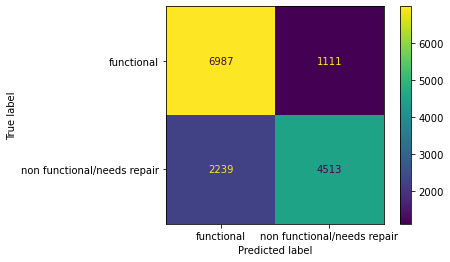

In [79]:
plot_confusion_matrix(rfc, X_te_pp, y_test);

In [80]:
precision_score(y_test, rfc.predict(X_te_pp), average='weighted')

0.7778393998743811

## Model 5: XG Boost

In [32]:
xgb_model = xgb.XGBClassifier(random_state=42, learning_rate=.25, 
                              max_depth=12, n_estimators=75)

xgb_model.fit(X_tr_pp, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=75, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
print(f"Train Score: {xgb_model.score(X_tr_pp, y_train)}")
print(f"Test Score: {xgb_model.score(X_te_pp, y_test)}")

Train Score: 0.8210998877665544
Test Score: 0.7825589225589226


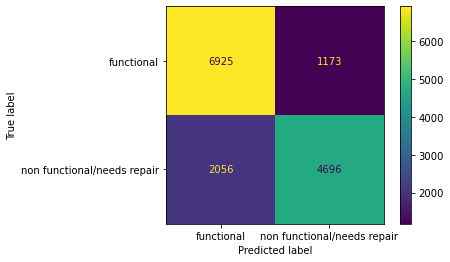

In [34]:
plot_confusion_matrix(xgb_model, X_te_pp, y_test);

## Model 6: Naive Bayes (Bernoulli)

In [35]:
nb = BernoulliNB()

nb.fit(X_tr_pp,y_train)

train_preds = nb.predict(X_tr_pp)
y_preds = nb.predict(X_te_pp)


print(f'Naive Bayes Train Accuracy: {accuracy_score(y_train, train_preds):.4f}')
print(f'Naive Bayes Test Accuracy: {accuracy_score(y_test, y_preds):.4f}')


Naive Bayes Train Accuracy: 0.6694
Naive Bayes Test Accuracy: 0.6646


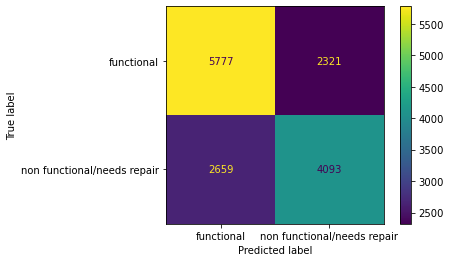

In [36]:
plot_confusion_matrix(nb, X_te_pp, y_test);

The models we decided to focus on were the XG Boost model and the Random Forest model.

## Tuning with GridSearchCV

We took our two best models and ran grid searches to find the best parameters to get the best precision score to lower the number of false positives. 

### Random Forest Model

In [37]:
rfc_cv = Pipeline(steps=[
    ('preprocessor', pp), 
    ('tree', RandomForestClassifier(max_depth=7, random_state=42))
])

In [38]:
param_grid = {
    'tree__n_estimators':[100, 150, 75],
    'tree__max_depth':[22, 30, 14, 5], 
    'tree__min_samples_leaf':[7, 45, 23]
}

In [39]:
y_train_fix = y_train.map({'functional': 1, 'non functional/needs repair':0})

In [40]:
gs_rfc = GridSearchCV(rfc_cv, param_grid, cv=5, scoring='f1')


gs_rfc.fit(X_train, y_train_fix)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['near_pop', 'has_static', 'has_year'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index([

In [41]:
gs_rfc.best_params_

{'tree__max_depth': 30, 'tree__min_samples_leaf': 7, 'tree__n_estimators': 100}

### XG Boost Model

In [42]:
xgb_cv = Pipeline(steps=[
    ('preprocessor', pp), 
    ('XGB', xgb.XGBClassifier())
])

In [43]:
param_xgb = {
    'XGB__n_estimators':[25, 75, 125], 
    'XGB__learning_rate':[.25, .5, .75],
    'XGB__max_depth':[5, 12, 20]
}

In [44]:
gs_xgb = GridSearchCV(xgb_cv, param_xgb, cv=5, scoring='accuracy')


gs_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['near_pop', 'has_static', 'has_year'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index([

In [45]:
gs_xgb.best_params_

{'XGB__learning_rate': 0.25, 'XGB__max_depth': 12, 'XGB__n_estimators': 75}